In [1]:
import pandas as pd
import numpy as np
import sys
import json 
import random
import math
import collections
import seaborn as sns
import networkx as nx

In [2]:
G = nx.read_graphml('pre2014.graphml')
print(len(G), len(G.edges))

5796 366988


In [3]:
dataset_edges = [e for e in G.edges if  int(G.edges[e]['first']) <20110700]

In [4]:
g = G.edge_subgraph(dataset_edges)

In [5]:
import stellargraph as sg
graph = sg.StellarGraph.from_networkx(g)

In [6]:
from stellargraph.data import EdgeSplitter
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 416 positive and 416 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 1162, Edges: 3752

 Node types:
  default: [1162]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [3752]
        Weights: all 1 (default)
        Features: none


In [7]:
from sklearn.model_selection import train_test_split
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, g)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 375 positive and 375 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 1162, Edges: 3377

 Node types:
  default: [1162]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [3377]
        Weights: all 1 (default)
        Features: none


In [8]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,562,Train Graph,Test Graph,Train the Link Classifier
Model Selection,188,Train Graph,Test Graph,Select the best Link Classifier model
Test set,832,Test Graph,Full Graph,Evaluate the best Link Classifier


In [9]:
import multiprocessing
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()

In [10]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec

def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [11]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 11620


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])

# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [13]:
def operator_hadamard(u, v):
    return u * v

def operator_l1(u, v):
    return np.abs(u - v)

def operator_l2(u, v):
    return (u - v) ** 2

def operator_avg(u, v):
    return (u + v) / 2.0

def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }

binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [14]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l1'


,ROC AUC score
name,
operator_hadamard,0.838435
operator_l1,0.889229
operator_l2,0.889229
operator_avg,0.685261


In [15]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 11620


In [16]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l1': 0.9295488165680473


In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

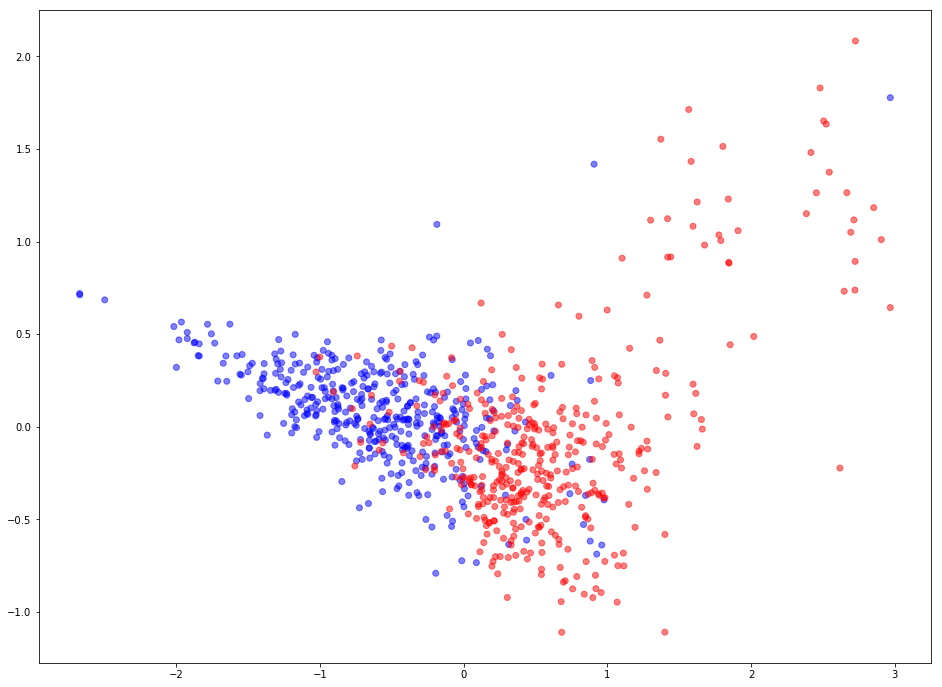

In [18]:
# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

In [19]:
X_transformed[:, 0]

array([-3.97139009e-01,  8.85902209e-02,  8.80793035e-02, -6.03145087e-01,
       -2.10436745e-01, -1.64894798e+00, -3.26056325e-01, -2.30666351e-01,
       -5.76878274e-01, -1.31533093e-01, -8.99163976e-01, -6.57901374e-01,
       -2.73403215e-01, -6.65450492e-01, -8.76077059e-01, -9.63250042e-01,
       -3.93681629e-01, -1.36821805e-01, -6.88919665e-01, -1.28788102e+00,
       -9.16750181e-01, -6.57166448e-01, -1.09010150e+00, -1.39056654e+00,
       -1.35327135e-02, -7.23402763e-01, -3.90429747e-01, -1.69204446e-01,
       -1.75611596e+00, -1.10849748e+00, -9.06802626e-01,  1.61571601e-02,
       -9.87087216e-01, -9.58339984e-02, -5.18937294e-01, -6.41742243e-01,
       -9.48126884e-03, -7.40777948e-01,  1.35101400e-01, -6.53628607e-01,
       -6.50463739e-01, -8.76577309e-03, -8.13731881e-01, -4.26172775e-01,
       -1.96496538e+00, -1.16395489e+00, -1.16449622e+00, -3.50832055e-01,
       -9.16426678e-01, -8.03144323e-02, -1.08578762e+00, -9.95733876e-01,
       -2.13716096e-02, -

In [20]:
link_features

[array([0.10952923, 0.20479777, 0.08717123, 0.30326757, 0.4799354 ,
        0.28253475, 0.23115832, 0.06131947, 0.14077856, 0.09460878,
        0.26557636, 0.33992985, 0.332463  , 0.07784565, 0.689986  ,
        0.07748231, 0.42205715, 0.18810037, 0.42867133, 0.02015736,
        0.3519225 , 0.3961351 , 0.04646188, 0.19666086, 0.25161007,
        0.07087265, 0.4001662 , 0.15346766, 0.3723309 , 0.37434247,
        0.3313193 , 0.44191018, 0.20238718, 0.3313138 , 0.29086992,
        0.11063614, 0.26228464, 0.24334583, 0.23331925, 0.5978774 ,
        0.70370275, 0.19093503, 0.5129559 , 0.2782836 , 0.0994241 ,
        0.12916908, 0.57413703, 0.19998947, 0.45181924, 0.04516824,
        0.3520516 , 0.06439161, 0.21849717, 0.04750577, 0.18171516,
        0.14468858, 0.16838431, 0.01903199, 0.17853868, 0.05952409,
        0.25871503, 0.07640977, 0.40045336, 0.10619034, 0.29000652,
        0.24979909, 0.47724688, 0.13034764, 0.52287567, 0.07102206,
        0.4840269 , 0.17543785, 0.4390466 , 0.16